# 🧠 Backpropagation: เรียนรู้ขั้นตอนการ Train Neural Network

**จุดประสงค์**: เข้าใจ Backpropagation - วิธีที่ Neural Network เรียนรู้จากข้อมูล

**โค้ดต้นฉบับ**: `machine_learning_examples-master/ann_class/backprop.py`

---

## 🎯 Backpropagation คืออะไร?

**Backpropagation** = วิธีคำนวณ **gradient** (ความชัน) เพื่ออัปเดต weights ให้โมเดลเรียนรู้

### 📚 แนวคิดพื้นฐาน:

1. **Forward Pass**: ส่งข้อมูลผ่าน network → ได้ prediction
2. **Calculate Loss**: เปรียบเทียบ prediction vs actual → ได้ error
3. **Backward Pass (Backprop)**: ส่ง error กลับไปหา gradient ของแต่ละ weight
4. **Update Weights**: ปรับ weights ตาม gradient
5. **Repeat**: วนซ้ำจนโมเดลเรียนรู้

---

## 🏗️ Network Architecture

```
Input (2D)  →  Hidden Layer (3 neurons, sigmoid)  →  Output (3 classes, softmax)
   X (N,2)         Z (N,3)                              Y (N,3)
              W1(2,3), b1(3)                        W2(3,3), b2(3)
```

### สูตร:

**Forward Pass**:
- Hidden: $Z = \sigma(X \cdot W1 + b1)$ ← sigmoid activation
- Output: $Y = \text{softmax}(Z \cdot W2 + b2)$

**Backward Pass** (Gradient Descent):
- $\frac{\partial L}{\partial W2} = Z^T \cdot (T - Y)$
- $\frac{\partial L}{\partial W1} = X^T \cdot [(T - Y) \cdot W2^T \odot Z \odot (1-Z)]$

---

## 📊 ข้อมูล

- **3 classes**: แต่ละ class มี 500 samples
- **2D input**: (x, y) coordinates
- **Task**: จำแนกว่าจุดอยู่ class ไหน

## 📦 Step 1: เตรียมความพร้อม

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import sys
import warnings
warnings.filterwarnings('ignore')

# ตั้งค่าฟอนต์ไทย
font_path = '../../font/Prompt/Prompt-Regular.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# เพิ่ม path
sys.path.append('../../machine_learning_examples-master')

# Set seed for reproducibility
np.random.seed(1)

print("✅ พร้อมเรียนรู้ Backpropagation!")

✅ พร้อมเรียนรู้ Backpropagation!


## 🔢 Step 2: สร้างข้อมูล (3 Classes)

**แนวคิด**: สร้าง 3 กลุ่มข้อมูล แต่ละกลุ่มอยู่คนละตำแหน่ง

- **Class 0** (สีม่วง): อยู่ล่าง (center = [0, -2])
- **Class 1** (สีเหลือง): อยู่ขวาบน (center = [2, 2])
- **Class 2** (สีเขียว): อยู่ซ้ายบน (center = [-2, 2])

In [3]:
# สร้างข้อมูล
Nclass = 500  # จำนวน samples ต่อ class
D = 2         # จำนวน features (2D: x, y)
M = 3         # จำนวน hidden neurons
K = 3         # จำนวน classes

# สร้าง 3 clusters
X1 = np.random.randn(Nclass, D) + np.array([0, -2])   # Class 0: ล่าง
X2 = np.random.randn(Nclass, D) + np.array([2, 2])    # Class 1: ขวาบน
X3 = np.random.randn(Nclass, D) + np.array([-2, 2])   # Class 2: ซ้ายบน

# รวมข้อมูล
X = np.vstack([X1, X2, X3])
Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)
N = len(Y)

# แปลง Y เป็น one-hot encoding (indicator matrix)
# เช่น: class 1 → [0, 1, 0]
T = np.zeros((N, K))
for i in range(N):
    T[i, Y[i]] = 1

print(f"✅ สร้างข้อมูลเรียบร้อย!")
print(f"📌 Total samples: {N}")
print(f"📌 X shape: {X.shape} (N x D)")
print(f"📌 Y shape: {Y.shape}")
print(f"📌 T shape (one-hot): {T.shape} (N x K)")

# แสดงตัวอย่าง one-hot encoding
print(f"\n💡 ตัวอย่าง One-Hot Encoding:")
print(f"   Y[0] = {Y[0]} → T[0] = {T[0]}")
print(f"   Y[500] = {Y[500]} → T[500] = {T[500]}")
print(f"   Y[1000] = {Y[1000]} → T[1000] = {T[1000]}")

✅ สร้างข้อมูลเรียบร้อย!
📌 Total samples: 1500
📌 X shape: (1500, 2) (N x D)
📌 Y shape: (1500,)
📌 T shape (one-hot): (1500, 3) (N x K)

💡 ตัวอย่าง One-Hot Encoding:
   Y[0] = 0 → T[0] = [1. 0. 0.]
   Y[500] = 1 → T[500] = [0. 1. 0.]
   Y[1000] = 2 → T[1000] = [0. 0. 1.]


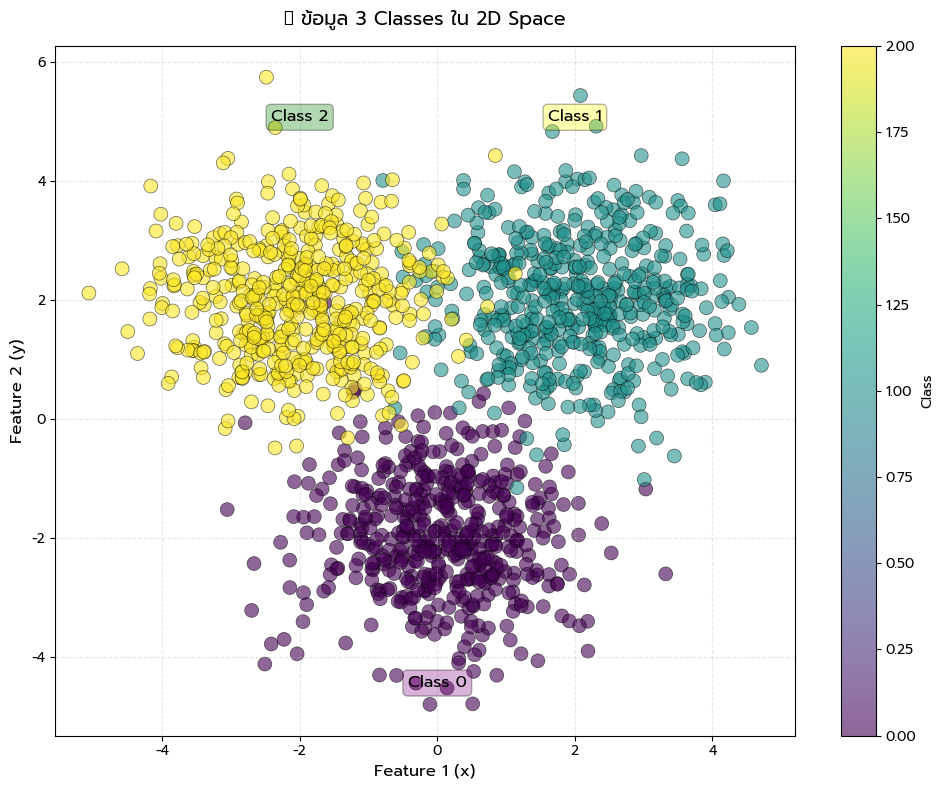

In [4]:
# Visualize ข้อมูล
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.6, cmap='viridis', edgecolors='black', linewidth=0.5)
plt.colorbar(label='Class')
plt.title('📊 ข้อมูล 3 Classes ใน 2D Space', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Feature 1 (x)', fontsize=12)
plt.ylabel('Feature 2 (y)', fontsize=12)
plt.grid(alpha=0.3, linestyle='--')

# เพิ่ม text บอกแต่ละ class
plt.text(0, -4.5, 'Class 0', fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='purple', alpha=0.3))
plt.text(2, 5, 'Class 1', fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
plt.text(-2, 5, 'Class 2', fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='green', alpha=0.3))

plt.tight_layout()
plt.show()

## 🔧 Step 3: สร้าง Helper Functions

### 3.1 Forward Pass Function

**แนวคิด**: ส่งข้อมูลผ่าน network เพื่อได้ prediction

```
Input X → Hidden Z (sigmoid) → Output Y (softmax)
```

In [5]:
def forward(X, W1, b1, W2, b2):
    """
    Forward Pass ผ่าน Neural Network
    
    Parameters:
    - X: input (N, D)
    - W1, b1: weights และ bias ของ hidden layer
    - W2, b2: weights และ bias ของ output layer
    
    Returns:
    - Y: output probabilities (N, K) - softmax
    - Z: hidden layer activations (N, M) - sigmoid
    """
    # Hidden Layer: Z = sigmoid(X · W1 + b1)
    Z = 1 / (1 + np.exp(-X.dot(W1) - b1))  # Sigmoid activation
    
    # Output Layer: Y = softmax(Z · W2 + b2)
    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA / expA.sum(axis=1, keepdims=True)  # Softmax
    
    return Y, Z

print("✅ Forward function พร้อมแล้ว!")
print("")
print("💡 ทำไมต้องใช้ Sigmoid และ Softmax?")
print("   • Sigmoid (hidden): บังคับค่าให้อยู่ 0-1, non-linear")
print("   • Softmax (output): แปลงเป็น probabilities (sum = 1)")

✅ Forward function พร้อมแล้ว!

💡 ทำไมต้องใช้ Sigmoid และ Softmax?
   • Sigmoid (hidden): บังคับค่าให้อยู่ 0-1, non-linear
   • Softmax (output): แปลงเป็น probabilities (sum = 1)


### 3.2 Classification Rate Function

**แนวคิด**: วัดว่าโมเดลทำนายถูกกี่ %

In [6]:
def classification_rate(Y, P):
    """
    คำนวณ accuracy: จำนวนที่ทำนายถูก / จำนวนทั้งหมด
    
    Parameters:
    - Y: true labels (N,)
    - P: predicted labels (N,)
    
    Returns:
    - accuracy (float)
    """
    n_correct = 0
    n_total = 0
    for i in range(len(Y)):
        n_total += 1
        if Y[i] == P[i]:
            n_correct += 1
    return float(n_correct) / n_total

print("✅ Classification rate function พร้อมแล้ว!")

✅ Classification rate function พร้อมแล้ว!


### 3.3 Cost Function (Loss)

**แนวคิด**: วัดว่าโมเดลทำนายผิดมากแค่ไหน

ใช้ **Cross-Entropy Loss**: $L = \sum T \cdot \log(Y)$

- ถ้าทำนายถูก (Y ใกล้ T) → Loss ต่ำ
- ถ้าทำนายผิด (Y ห่างจาก T) → Loss สูง

In [7]:
def cost(T, Y):
    """
    Cross-Entropy Loss
    
    Parameters:
    - T: true labels (one-hot) (N, K)
    - Y: predicted probabilities (N, K)
    
    Returns:
    - loss (scalar)
    """
    tot = T * np.log(Y)
    return tot.sum()

print("✅ Cost function พร้อมแล้ว!")
print("")
print("💡 Cross-Entropy Loss:")
print("   • เหมาะกับ classification problems")
print("   • ยิ่ง loss ต่ำ → โมเดลยิ่งดี")

✅ Cost function พร้อมแล้ว!

💡 Cross-Entropy Loss:
   • เหมาะกับ classification problems
   • ยิ่ง loss ต่ำ → โมเดลยิ่งดี


## 🎓 Step 4: Gradient Functions (Backpropagation)

**แนวคิด**: คำนวณ gradient ของแต่ละ parameter เพื่อใช้ update weights

### 🧮 คณิตศาสตร์ (สั้นๆ):

**Output Layer**:
- $\frac{\partial L}{\partial W2} = Z^T \cdot (T - Y)$
- $\frac{\partial L}{\partial b2} = \sum (T - Y)$

**Hidden Layer** (ต้อง backprop ผ่าน W2):
- $\frac{\partial L}{\partial W1} = X^T \cdot [(T - Y) \cdot W2^T \odot Z \odot (1-Z)]$
- $\frac{\partial L}{\partial b1} = \sum [(T - Y) \cdot W2^T \odot Z \odot (1-Z)]$

โดย $\odot$ = element-wise multiplication

In [8]:
def derivative_w2(Z, T, Y):
    """
    Gradient ของ W2 (output layer weights)
    
    สูตร: dL/dW2 = Z^T · (T - Y)
    
    Intuition: ความผิดพลาด (T-Y) ถูก "ส่งกลับ" ผ่าน hidden activations Z
    """
    return Z.T.dot(T - Y)

def derivative_b2(T, Y):
    """
    Gradient ของ b2 (output layer bias)
    
    สูตร: dL/db2 = Σ(T - Y)
    """
    return (T - Y).sum(axis=0)

def derivative_w1(X, Z, T, Y, W2):
    """
    Gradient ของ W1 (hidden layer weights)
    
    สูตร: dL/dW1 = X^T · [(T-Y)·W2^T ⊙ Z ⊙ (1-Z)]
    
    Intuition:
    1. (T-Y) = error ที่ output
    2. (T-Y)·W2^T = backprop error ผ่าน W2 กลับไปที่ hidden
    3. Z·(1-Z) = derivative ของ sigmoid
    4. X^T· = คูณกับ input เพื่อได้ gradient
    """
    dZ = (T - Y).dot(W2.T) * Z * (1 - Z)  # Chain rule
    return X.T.dot(dZ)

def derivative_b1(T, Y, W2, Z):
    """
    Gradient ของ b1 (hidden layer bias)
    
    สูตร: dL/db1 = Σ[(T-Y)·W2^T ⊙ Z ⊙ (1-Z)]
    """
    return ((T - Y).dot(W2.T) * Z * (1 - Z)).sum(axis=0)

print("✅ Gradient functions (Backpropagation) พร้อมแล้ว!")
print("")
print("💡 ทำไมต้อง Backpropagation?")
print("   • Forward Pass: ทำนาย → ได้ error")
print("   • Backward Pass: ส่ง error กลับไปหา gradient")
print("   • Gradient บอกว่า weight ไหนต้องปรับแค่ไหน")

✅ Gradient functions (Backpropagation) พร้อมแล้ว!

💡 ทำไมต้อง Backpropagation?
   • Forward Pass: ทำนาย → ได้ error
   • Backward Pass: ส่ง error กลับไปหา gradient
   • Gradient บอกว่า weight ไหนต้องปรับแค่ไหน


## 🏋️ Step 5: Initialize Weights

**แนวคิด**: สุ่ม weights เริ่มต้นด้วยค่าเล็กๆ

- ถ้า weights = 0 ทั้งหมด → โมเดลไม่เรียนรู้ (symmetry breaking)
- ถ้า weights ใหญ่เกินไป → gradient explode

In [9]:
# สุ่ม weights เริ่มต้น
W1 = np.random.randn(D, M)  # (2, 3)
b1 = np.random.randn(M)     # (3,)
W2 = np.random.randn(M, K)  # (3, 3)
b2 = np.random.randn(K)     # (3,)

print("✅ Weights initialized!")
print(f"")
print(f"📌 W1 shape: {W1.shape} (D x M)")
print(f"📌 b1 shape: {b1.shape} (M,)")
print(f"📌 W2 shape: {W2.shape} (M x K)")
print(f"📌 b2 shape: {b2.shape} (K,)")
print(f"")
print(f"💡 ตัวอย่างค่า weights เริ่มต้น:")
print(f"   W1[0] = {W1[0]}")
print(f"   b1 = {b1}")

✅ Weights initialized!

📌 W1 shape: (2, 3) (D x M)
📌 b1 shape: (3,) (M,)
📌 W2 shape: (3, 3) (M x K)
📌 b2 shape: (3,) (K,)

💡 ตัวอย่างค่า weights เริ่มต้น:
   W1[0] = [-0.07710696  0.20782527  0.98619593]
   b1 = [ 0.69172086 -0.79834675  0.21381773]


## 🚀 Step 6: Training Loop (Gradient Ascent)

**แนวคิด**: วนซ้ำหลายๆ epochs เพื่อปรับ weights ให้โมเดลเรียนรู้

### ขั้นตอนในแต่ละ epoch:

1. **Forward Pass**: คำนวณ output
2. **Calculate Cost**: วัด loss
3. **Backward Pass**: คำนวณ gradients
4. **Update Weights**: $W = W + \text{learning\_rate} \times \text{gradient}$

**หมายเหตุ**: ใช้ **Gradient ASCENT** (บวก gradient) เพราะ cost function เป็น log-likelihood (ยิ่งสูงยิ่งดี)

In [10]:
learning_rate = 1e-3  # 0.001
epochs = 1000
costs = []
accuracies = []

print("🏋️ เริ่ม Training...\n")

for epoch in range(epochs):
    # 1. Forward Pass
    output, hidden = forward(X, W1, b1, W2, b2)
    
    # 2. Calculate Cost และ Accuracy
    if epoch % 100 == 0:
        c = cost(T, output)
        P = np.argmax(output, axis=1)  # เลือก class ที่มี prob สูงสุด
        r = classification_rate(Y, P)
        
        print(f"Epoch {epoch:4d} | Cost: {c:10.2f} | Accuracy: {r:.4f} ({r*100:.2f}%)")
        
        costs.append(c)
        accuracies.append(r)
    
    # 3. Backward Pass (คำนวณ gradients)
    gW2 = derivative_w2(hidden, T, output)
    gb2 = derivative_b2(T, output)
    gW1 = derivative_w1(X, hidden, T, output, W2)
    gb1 = derivative_b1(T, output, W2, hidden)
    
    # 4. Update Weights (Gradient ASCENT - เพิ่ม gradient)
    W2 += learning_rate * gW2
    b2 += learning_rate * gb2
    W1 += learning_rate * gW1
    b1 += learning_rate * gb1

print("\n✅ Training เสร็จแล้ว!")

🏋️ เริ่ม Training...

Epoch    0 | Cost:   -3147.18 | Accuracy: 0.2687 (26.87%)
Epoch  100 | Cost:    -142.76 | Accuracy: 0.9680 (96.80%)
Epoch  200 | Cost:    -123.09 | Accuracy: 0.9693 (96.93%)
Epoch  300 | Cost:    -118.58 | Accuracy: 0.9693 (96.93%)
Epoch  200 | Cost:    -123.09 | Accuracy: 0.9693 (96.93%)
Epoch  300 | Cost:    -118.58 | Accuracy: 0.9693 (96.93%)
Epoch  400 | Cost:    -116.68 | Accuracy: 0.9687 (96.87%)
Epoch  400 | Cost:    -116.68 | Accuracy: 0.9687 (96.87%)
Epoch  500 | Cost:    -115.59 | Accuracy: 0.9693 (96.93%)
Epoch  500 | Cost:    -115.59 | Accuracy: 0.9693 (96.93%)
Epoch  600 | Cost:    -114.87 | Accuracy: 0.9700 (97.00%)
Epoch  700 | Cost:    -114.32 | Accuracy: 0.9700 (97.00%)
Epoch  800 | Cost:    -113.88 | Accuracy: 0.9700 (97.00%)
Epoch  600 | Cost:    -114.87 | Accuracy: 0.9700 (97.00%)
Epoch  700 | Cost:    -114.32 | Accuracy: 0.9700 (97.00%)
Epoch  800 | Cost:    -113.88 | Accuracy: 0.9700 (97.00%)
Epoch  900 | Cost:    -113.52 | Accuracy: 0.9700 (

## 📊 Step 7: Visualize Training Progress

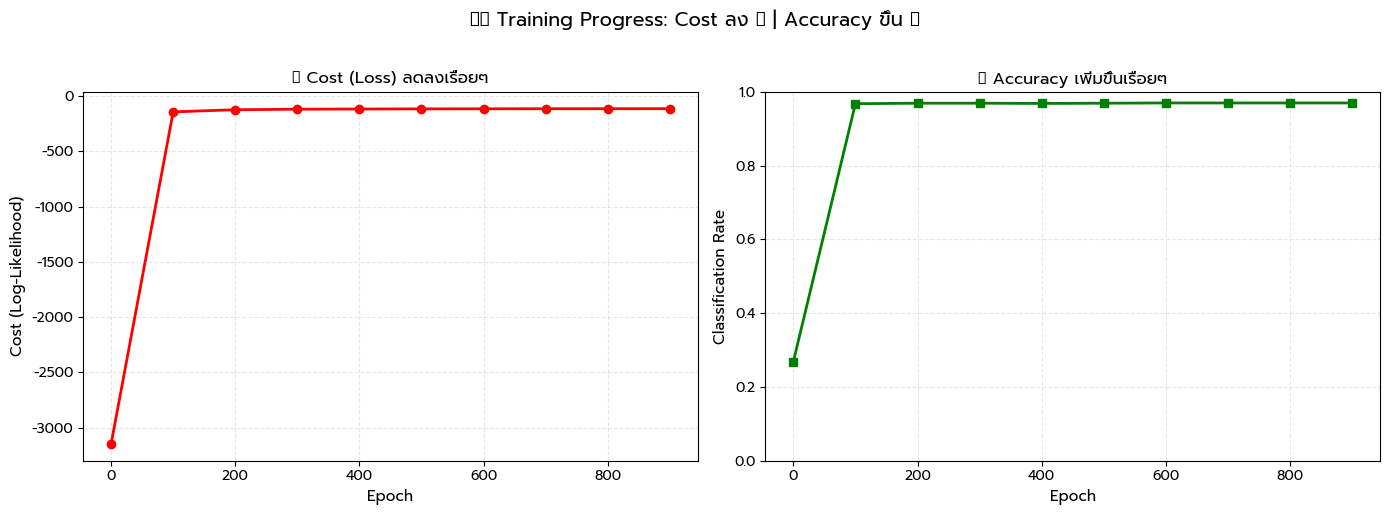


📊 สรุปผลลัพธ์:
   • Cost เริ่มต้น: -3147.18
   • Cost สุดท้าย: -113.52
   • Accuracy เริ่มต้น: 26.87%
   • Accuracy สุดท้าย: 97.00%


In [11]:
# Plot Cost และ Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Cost (Loss)
axes[0].plot(range(0, epochs, 100), costs, linewidth=2, marker='o', markersize=6, color='red')
axes[0].set_title('📉 Cost (Loss) ลดลงเรื่อยๆ', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Cost (Log-Likelihood)', fontsize=11)
axes[0].grid(alpha=0.3, linestyle='--')

# Plot 2: Accuracy
axes[1].plot(range(0, epochs, 100), accuracies, linewidth=2, marker='s', markersize=6, color='green')
axes[1].set_title('📈 Accuracy เพิ่มขึ้นเรื่อยๆ', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Classification Rate', fontsize=11)
axes[1].set_ylim([0, 1.0])
axes[1].grid(alpha=0.3, linestyle='--')

plt.suptitle('🏋️ Training Progress: Cost ลง ↘ | Accuracy ขึ้น ↗', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n📊 สรุปผลลัพธ์:")
print(f"   • Cost เริ่มต้น: {costs[0]:.2f}")
print(f"   • Cost สุดท้าย: {costs[-1]:.2f}")
print(f"   • Accuracy เริ่มต้น: {accuracies[0]*100:.2f}%")
print(f"   • Accuracy สุดท้าย: {accuracies[-1]*100:.2f}%")

## 🎯 Step 8: Visualize Decision Boundary

**แนวคิด**: ดูว่าโมเดลเรียนรู้แบ่ง classes ได้ดีแค่ไหน

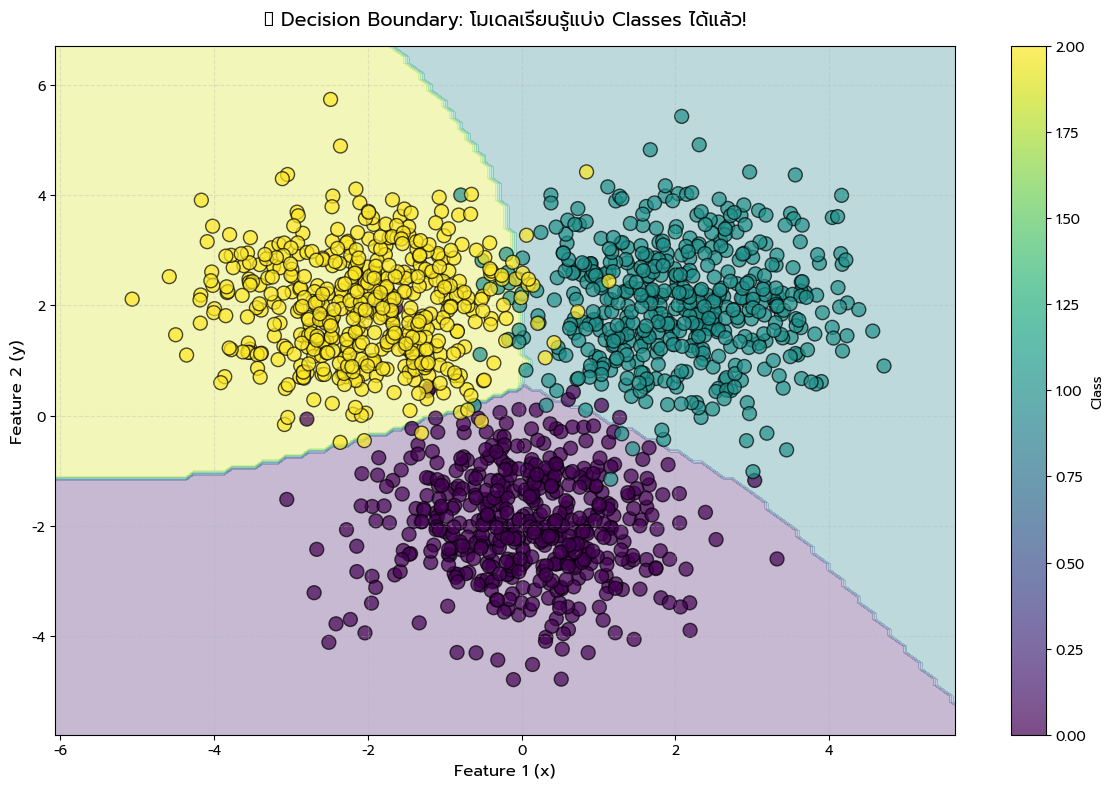


🏆 Final Accuracy: 97.00%
   ทำนายถูก 1455/1500 samples


In [12]:
# สร้าง grid สำหรับ plot decision boundary
h = 0.1  # step size
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# ทำนายทุกจุดใน grid
Z_grid = np.c_[xx.ravel(), yy.ravel()]
predictions, _ = forward(Z_grid, W1, b1, W2, b2)
predictions = np.argmax(predictions, axis=1)
predictions = predictions.reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 8))

# Plot decision boundary (background)
plt.contourf(xx, yy, predictions, alpha=0.3, cmap='viridis')

# Plot data points
plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, alpha=0.7, cmap='viridis', 
            edgecolors='black', linewidth=1)

plt.title('🎯 Decision Boundary: โมเดลเรียนรู้แบ่ง Classes ได้แล้ว!', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Feature 1 (x)', fontsize=12)
plt.ylabel('Feature 2 (y)', fontsize=12)
plt.colorbar(label='Class')
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Final accuracy
final_output, _ = forward(X, W1, b1, W2, b2)
final_predictions = np.argmax(final_output, axis=1)
final_accuracy = classification_rate(Y, final_predictions)

print(f"\n🏆 Final Accuracy: {final_accuracy*100:.2f}%")
print(f"   ทำนายถูก {int(final_accuracy*N)}/{N} samples")

## 🎓 สรุปสุดท้าย: Backpropagation คืออะไร?

### 🔑 Key Concepts:

#### 1️⃣ **Forward Pass**:
```
Input X → Hidden Z (sigmoid) → Output Y (softmax)
```
- ส่งข้อมูลผ่าน network
- ได้ prediction (Y)

#### 2️⃣ **Calculate Loss**:
```
Loss = Cross-Entropy(T, Y)
```
- วัดว่าทำนายผิดมากแค่ไหน

#### 3️⃣ **Backward Pass (Backpropagation)**:
```
Output Layer: dL/dW2 = Z^T · (T - Y)
Hidden Layer: dL/dW1 = X^T · [(T-Y)·W2^T ⊙ Z·(1-Z)]
```
- ส่ง error กลับไปหา gradient
- ใช้ Chain Rule เชื่อม gradients จาก output → hidden

#### 4️⃣ **Update Weights**:
```
W = W + learning_rate × gradient
```
- ปรับ weights ตาม gradient
- ทำซ้ำจนโมเดลเรียนรู้

---

### 💡 ทำไมต้องใช้ Backpropagation?

- **ปัญหา**: Neural Network มี weights หลายชั้น จะคำนวณ gradient ยังไง?
- **วิธีแก้**: Backpropagation = ใช้ Chain Rule ส่ง gradient กลับทีละชั้น
- **ผลลัพธ์**: คำนวณ gradient ได้อย่างมีประสิทธิภาพ!

---

### 🎯 จุดสำคัญที่ต้องเข้าใจ:

| Concept | คำอธิบาย | ตัวอย่าง |
|---------|---------|----------|
| **Forward Pass** | ทำนาย | X → Z → Y |
| **Loss Function** | วัด error | Cross-Entropy |
| **Gradient** | ความชัน | dL/dW1, dL/dW2 |
| **Backpropagation** | ส่ง gradient กลับ | Chain Rule |
| **Gradient Ascent** | อัปเดต weights | W += lr × grad |

---

### 🚀 ขั้นตอนต่อไป:

1. **ลองเปลี่ยน Hyperparameters**:
   - Learning rate (1e-3 → 1e-2 หรือ 1e-4)
   - Hidden layer size (M = 3 → 5, 10, 20)
   - Epochs (1000 → 2000)

2. **ลองข้อมูลอื่น**:
   - เพิ่มจำนวน classes (K = 4, 5)
   - เพิ่มจำนวน features (D = 3, 4)

3. **เพิ่มชั้น Hidden**:
   - 2 hidden layers แทน 1
   - ดู Deep Learning!

---

### 📚 อ่านเพิ่มเติม:

- **`ann.ipynb`**: เรียนรู้ ANN สำหรับ Time Series
- **`rnn.ipynb`**: เรียนรู้ RNN/GRU
- **Lazy Programmer Course**: https://lazyprogrammer.me

---

## 🎉 สรุปสั้นๆ:

> **"Backpropagation = วิธีที่ Neural Network เรียนรู้จากข้อมูล"**

**Process**:
1. **Forward**: คำนวณ prediction
2. **Loss**: วัด error
3. **Backward**: หา gradient (Chain Rule)
4. **Update**: ปรับ weights
5. **Repeat**: จนเรียนรู้!

✨ **Happy Learning & Happy Backpropagating!** ✨